# 1) Prepare Machine
- Mount google drive
- Clone ssd-keras repository
- Download and prepare VOC07 and VOC12 datasets

In [0]:
#Some Settings for Preparing emilia-colab!
set_mount_drive = True
set_clone_repo = True
set_prepare_voc = False #Only use if you don't have the VOC7+12 HDF5s in your gdrive
set_install_tfgpu = True



In [0]:
if set_mount_drive:
  
  from google.colab import drive
  drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
%%capture
if set_clone_repo:

  !git clone https://github.com/henritomas/ssd-keras.git

In [0]:
%%capture
if set_install_tfgpu:
  
  !pip install tensorflow-gpu==1.15.*
  !pip install larq

In [0]:
import os
import pathlib

def folder_not_here(FOLDER_PATH):
  if FOLDER_PATH in pathlib.Path.cwd().parts:
    while FOLDER_PATH in pathlib.Path.cwd().parts:
      return False
  elif not pathlib.Path(FOLDER_PATH).exists():
      return True

In [0]:
%cd /content/
#PJREDDIE's mirror sometimes the server is randomly slow to download, Oxford's server more consistent
# http://host.robots.ox.ac.uk/pascal/VOC/

if set_prepare_voc:

  !wget http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtrainval_06-Nov-2007.tar
  !wget http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtest_06-Nov-2007.tar
  !wget http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar

/content


In [0]:
%%capture
if set_prepare_voc:

  VOC_IMAGES_DIR = '/content/voc7+12_images'

  !tar -xvf "/content/VOCtrainval_06-Nov-2007.tar"
  !tar -xvf "/content/VOCtest_06-Nov-2007.tar"
  !tar -xvf "/content/VOCtrainval_11-May-2012.tar"

  !mkdir $VOC_IMAGES_DIR
  !mv -v /content/VOCdevkit/VOC2007/JPEGImages/* $VOC_IMAGES_DIR
  !mv -v /content/VOCdevkit/VOC2012/JPEGImages/* $VOC_IMAGES_DIR

  !mv /content/ssd-keras/dataset_voc_csv/2007_2012_person_trainval.csv $VOC_IMAGES_DIR
  !mv /content/ssd-keras/dataset_voc_csv/2007_person_test.csv $VOC_IMAGES_DIR

# 2) Start of actual Jupyter Notebook

In [0]:
%cd /content/ssd-keras/

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TerminateOnNaN, CSVLogger
from tensorflow.keras import backend as K
from tensorflow.keras.models import load_model
from math import ceil
import numpy as np
from matplotlib import pyplot as plt

from models.tfkeras_ssd7 import build_model
from keras_loss_function.keras_ssd_loss import SSDLoss
from keras_layers.tensorflow_keras_layer_AnchorBoxes import AnchorBoxes
from keras_layers.tensorflow_keras_layer_DecodeDetections import DecodeDetections
from keras_layers.tensorflow_keras_layer_DecodeDetectionsFast import DecodeDetectionsFast

from ssd_encoder_decoder.ssd_input_encoder import SSDInputEncoder
from ssd_encoder_decoder.ssd_output_decoder import decode_detections, decode_detections_fast

from data_generator.tensorflow_object_detection_2d_data_generator import DataGenerator
from data_generator.object_detection_2d_misc_utils import apply_inverse_transforms
from data_generator.data_augmentation_chain_variable_input_size import DataAugmentationVariableInputSize
from data_generator.data_augmentation_chain_constant_input_size import DataAugmentationConstantInputSize
from data_generator.data_augmentation_chain_original_ssd import SSDDataAugmentation

from data_generator.object_detection_2d_geometric_ops import Resize
from data_generator.object_detection_2d_photometric_ops import ConvertTo3Channels
from data_generator.object_detection_2d_misc_utils import apply_inverse_transforms

%matplotlib inline

/content/ssd-keras


Using TensorFlow backend.


In [0]:
img_height = 300 # Height of the input images
img_width = 480 # Width of the input images
img_channels = 3 # Number of color channels of the input images
swap_channels = [2, 1, 0] # The color channel order in the original SSD is BGR, so we'll have the model reverse the color channel order of the input images.
intensity_mean = 127.5 # Set this to your preference (maybe `None`). The current settings transform the input pixel values to the interval `[-1,1]`.
intensity_range = 127.5 # Set this to your preference (maybe `None`). The current settings transform the input pixel values to the interval `[-1,1]`.
n_classes = 1 # Number of positive classes
scales = [0.08, 0.16, 0.32, 0.64, 0.96] # An explicit list of anchor box scaling factors. If this is passed, it will override `min_scale` and `max_scale`.
aspect_ratios = [0.5, 1.0, 2.0] # The list of aspect ratios for the anchor boxes
two_boxes_for_ar1 = True # Whether or not you want to generate two anchor boxes for aspect ratio 1
steps = None # In case you'd like to set the step sizes for the anchor box grids manually; not recommended
offsets = None # In case you'd like to set the offsets for the anchor box grids manually; not recommended
clip_boxes = False # Whether or not to clip the anchor boxes to lie entirely within the image boundaries
variances = [1.0, 1.0, 1.0, 1.0] # The list of variances by which the encoded target coordinates are scaled
normalize_coords = True # Whether or not the model is supposed to use coordinates relative to the image size

In [0]:
# 1: Build the Keras model

K.clear_session() # Clear previous models from memory.

model = build_model(image_size=(img_height, img_width, img_channels),
                    n_classes=n_classes,
                    mode='training',
                    l2_regularization=0.0005,
                    scales=scales,
                    aspect_ratios_global=aspect_ratios,
                    aspect_ratios_per_layer=None,
                    two_boxes_for_ar1=two_boxes_for_ar1,
                    steps=steps,
                    offsets=offsets,
                    clip_boxes=clip_boxes,
                    variances=variances,
                    normalize_coords=normalize_coords,
                    subtract_mean=intensity_mean,
                    divide_by_stddev=intensity_range,
                    swap_channels=swap_channels)

# 2: Optional: Load some weights

#model.load_weights('./ssd7_weights.h5', by_name=True)

# 3: Instantiate an Adam optimizer and the SSD loss function and compile the model

adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

ssd_loss = SSDLoss(neg_pos_ratio=3, alpha=1.0)

model.compile(optimizer=adam, loss=ssd_loss.compute_loss)

In [0]:
import os
GDRIVE = '/content/gdrive/My Drive/emilia-colab/ssd-keras/'
VOC_HDF5_TRAIN = os.path.join(GDRIVE, 'dataset_hdf5/voc7-12_person_trainval.h5')
VOC_HDF5_TEST = os.path.join(GDRIVE, 'dataset_hdf5/voc7-12_person_test.h5')

SAVED_MODEL = os.path.join(GDRIVE, 'ssd7_voc_person/ssd7_epoch-81_loss-2.20_val_loss-2.15.h5')

In [0]:
# TODO: Set the path to the `.h5` file of the model to be loaded.
model_path = SAVED_MODEL

# We need to create an SSDLoss object in order to pass that to the model loader.
ssd_loss = SSDLoss(neg_pos_ratio=3, alpha=1.0)

K.clear_session() # Clear previous models from memory.

model = load_model(model_path, custom_objects={'AnchorBoxes': AnchorBoxes,
                                               'compute_loss': ssd_loss.compute_loss})

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Instructions for updating:
Use `tf.cast` instead.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
Use `tf.cast` instead.


In [0]:
# 1: Instantiate two `DataGenerator` objects: One for training, one for validation.

# Optional: If you have enough memory, consider loading the images into memory for the reasons explained above.

train_dataset = DataGenerator(load_images_into_memory=False, hdf5_dataset_path=VOC_HDF5_TRAIN)
val_dataset = DataGenerator(load_images_into_memory=False, hdf5_dataset_path=VOC_HDF5_TEST)
#train_dataset = DataGenerator(load_images_into_memory=False, hdf5_dataset_path=None)
#val_dataset = DataGenerator(load_images_into_memory=False, hdf5_dataset_path=None)

# 2: Parse the image and label lists for the training and validation datasets.

# TODO: Set the paths to your dataset here.

# Images
#images_dir = '/content/voc7+12_images/'

# Ground truth
#train_labels_filename = '/content/voc7+12_images/2007_2012_person_trainval.csv'
#val_labels_filename   = '/content/voc7+12_images/2007_person_test.csv'

#train_dataset.parse_csv(images_dir=images_dir,
#                        labels_filename=train_labels_filename,
#                        input_format=['image_name', 'xmin', 'ymin', 'xmax', 'ymax', 'class_id'], # This is the order of the first six columns in the CSV file that contains the labels for your dataset. If your labels are in XML format, maybe the XML parser will be helpful, check the documentation.
#                        include_classes='all')

#val_dataset.parse_csv(images_dir=images_dir,
#                      labels_filename=val_labels_filename,
#                      input_format=['image_name', 'xmin', 'ymin', 'xmax', 'ymax', 'class_id'],
#                      include_classes='all')

# Optional: Convert the dataset into an HDF5 dataset. This will require more disk space, but will
# speed up the training. Doing this is not relevant in case you activated the `load_images_into_memory`
# option in the constructor, because in that cas the images are in memory already anyway. If you don't
# want to create HDF5 datasets, comment out the subsequent two function calls.

#train_dataset.create_hdf5_dataset(file_path=VOC_HDF5_TRAIN,
#                                  resize=False,
#                                  variable_image_size=True,
#                                  verbose=True)

#val_dataset.create_hdf5_dataset(file_path=VOC_HDF5_TEST,
#                                resize=False,
#                                variable_image_size=True,
#                                verbose=True)

# Get the number of samples in the training and validations datasets.
train_dataset_size = train_dataset.get_dataset_size()
val_dataset_size   = val_dataset.get_dataset_size()

print("Number of images in the training dataset:\t{:>6}".format(train_dataset_size))
print("Number of images in the validation dataset:\t{:>6}".format(val_dataset_size))

Loading image IDs: 100%|██████████| 2007/2007 [00:00<00:00, 10160.16it/s]
Number of images in the training dataset:	  6095
Number of images in the validation dataset:	  2007


In [0]:
# 3: Set the batch size.

batch_size = 32

# 4: Define the image processing chain.

ssd_data_augmentation = SSDDataAugmentation(img_height=img_height,
                                            img_width=img_width,)
                                            #background=mean_color)
    
convert_to_3_channels = ConvertTo3Channels()
resize = Resize(height=img_height, width=img_width)

# 5: Instantiate an encoder that can encode ground truth labels into the format needed by the SSD loss function.

# The encoder constructor needs the spatial dimensions of the model's predictor layers to create the anchor boxes.
predictor_sizes = [model.get_layer('classes4').output_shape[1:3],
                   model.get_layer('classes5').output_shape[1:3],
                   model.get_layer('classes6').output_shape[1:3],
                   model.get_layer('classes7').output_shape[1:3]]

ssd_input_encoder = SSDInputEncoder(img_height=img_height,
                                    img_width=img_width,
                                    n_classes=n_classes,
                                    predictor_sizes=predictor_sizes,
                                    scales=scales,
                                    aspect_ratios_global=aspect_ratios,
                                    two_boxes_for_ar1=two_boxes_for_ar1,
                                    steps=steps,
                                    offsets=offsets,
                                    clip_boxes=clip_boxes,
                                    variances=variances,
                                    matching_type='multi',
                                    pos_iou_threshold=0.5,
                                    neg_iou_limit=0.3,
                                    normalize_coords=normalize_coords)

# 6: Create the generator handles that will be passed to Keras' `fit_generator()` function.

train_generator = train_dataset.generate(batch_size=batch_size,
                                         shuffle=True,
                                         transformations=[ssd_data_augmentation],
                                         label_encoder=ssd_input_encoder,
                                         returns={'processed_images',
                                                  'encoded_labels'},
                                         keep_images_without_gt=False)

val_generator = val_dataset.generate(batch_size=batch_size,
                                     shuffle=False,
                                     transformations=[convert_to_3_channels,
                                                      resize],
                                     label_encoder=ssd_input_encoder,
                                     returns={'processed_images',
                                              'encoded_labels'},
                                     keep_images_without_gt=False)

In [0]:
#%mkdir '/content/gdrive/My Drive/emilia-colab/ssd-keras/ssd7_voc_person'
WEIGHTS_DIR = os.path.join(GDRIVE, 'ssd7_voc_person/ssd7_epoch-{epoch:02d}_loss-{loss:.2f}_val_loss-{val_loss:.2f}.h5')
LOG_DIR = os.path.join(GDRIVE, 'ssd7_voc_person/ssd7_training_log.csv')

In [0]:
# Define model callbacks.

# TODO: Set the filepath under which you want to save the weights.
model_checkpoint = ModelCheckpoint(filepath=WEIGHTS_DIR,
                                   monitor='val_loss',
                                   verbose=1,
                                   save_best_only=True,
                                   save_weights_only=False,
                                   mode='auto',
                                   period=1)

csv_logger = CSVLogger(filename=LOG_DIR,
                       separator=',',
                       append=True)

early_stopping = EarlyStopping(monitor='val_loss',
                               min_delta=0.0,
                               patience=10,
                               verbose=1)

reduce_learning_rate = ReduceLROnPlateau(monitor='val_loss',
                                         factor=0.1,
                                         patience=8,
                                         verbose=1,
                                         epsilon=0.001,
                                         cooldown=0,
                                         min_lr=1e-5)

callbacks = [model_checkpoint,
             csv_logger,
             early_stopping,
             reduce_learning_rate]

In [0]:
# TODO: Set the epochs to train for.
# If you're resuming a previous training, set `initial_epoch` and `final_epoch` accordingly.
initial_epoch   = 83
final_epoch     = 200
steps_per_epoch = train_dataset_size//batch_size

history = model.fit_generator(generator=train_generator,
                              steps_per_epoch=steps_per_epoch,
                              epochs=final_epoch,
                              callbacks=callbacks,
                              validation_data=val_generator,
                              validation_steps=ceil(val_dataset_size/batch_size),
                              initial_epoch=initial_epoch)

Epoch 84/200
 63/190 [========>.....................] - ETA: 1:46 - loss: 2.1628
Epoch 00084: val_loss improved from inf to 2.16275, saving model to /content/gdrive/My Drive/emilia-colab/ssd-keras/ssd7_voc_person/ssd7_epoch-84_loss-2.20_val_loss-2.16.h5
190/190 [==============================] - 332s 2s/step - loss: 2.2023 - val_loss: 2.1628
Epoch 85/200
 63/190 [========>.....................] - ETA: 1:47 - loss: 2.2333
Epoch 00085: val_loss did not improve from 2.16275
190/190 [==============================] - 302s 2s/step - loss: 2.1914 - val_loss: 2.2333
Epoch 86/200
 63/190 [========>.....................] - ETA: 1:45 - loss: 2.1910
Epoch 00086: val_loss did not improve from 2.16275
190/190 [==============================] - 294s 2s/step - loss: 2.1961 - val_loss: 2.1910
Epoch 87/200
 63/190 [========>.....................] - ETA: 1:10 - loss: 2.2554
Epoch 00087: val_loss did not improve from 2.16275
190/190 [==============================] - 271s 1s/step - loss: 2.2032 - val_los

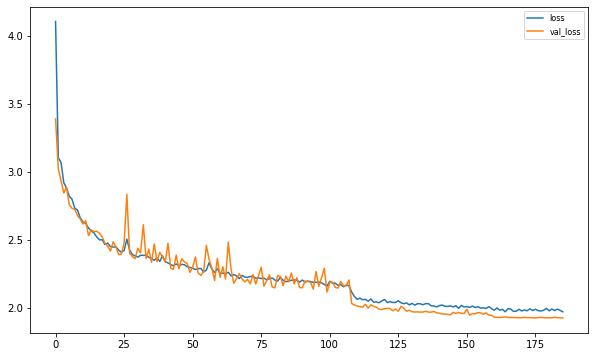

In [0]:
import pandas as pd
import matplotlib.pyplot as plt

record_df = pd.read_csv(LOG_DIR)
#print(record_df['loss'])

plt.figure(figsize=(10,6))
plt.plot(record_df['loss'], label='loss')
plt.plot(record_df['val_loss'], label='val_loss')
plt.legend(loc='upper right', prop={'size': 8});

In [0]:
# 1: Set the generator for the predictions.

predict_generator = val_dataset.generate(batch_size=1,
                                         shuffle=True,
                                         transformations=[convert_to_3_channels,
                                                          resize],
                                         label_encoder=None,
                                         returns={'processed_images',
                                                  'filenames',
                                                  'inverse_transform',
                                                  'original_images',
                                                  'original_labels'},
                                         keep_images_without_gt=False)

In [0]:
# 2: Generate samples

batch_images, batch_filenames, batch_inverse_transforms, batch_original_images, batch_original_labels = next(predict_generator)

i = 0 # Which batch item to look at

try:
    print("Image:", batch_filenames[i])
except:
    print("Using hdf5 cache: No image filepath")
print()
print("Ground truth boxes:\n")
print(np.array(batch_original_labels[i]))

Using hdf5 cache: No image filepath

Ground truth boxes:

[[  1 176  52 278 224]]


In [0]:
# 3: Make a prediction

y_pred = model.predict(batch_images)

# 4: Decode the raw predictions in `y_pred`.

y_pred_decoded = decode_detections(y_pred,
                                   confidence_thresh=0.5,
                                   iou_threshold=0.4,
                                   top_k=200,
                                   normalize_coords=normalize_coords,
                                   img_height=img_height,
                                   img_width=img_width)

# 5: Convert the predictions for the original image.

y_pred_decoded_inv = apply_inverse_transforms(y_pred_decoded, batch_inverse_transforms)

np.set_printoptions(precision=2, suppress=True, linewidth=90)
print("Predicted boxes:\n")
print('   class   conf xmin   ymin   xmax   ymax')
print(y_pred_decoded_inv[i])

Predicted boxes:

   class   conf xmin   ymin   xmax   ymax
[[  1.     0.96 173.    49.   296.   237.  ]]


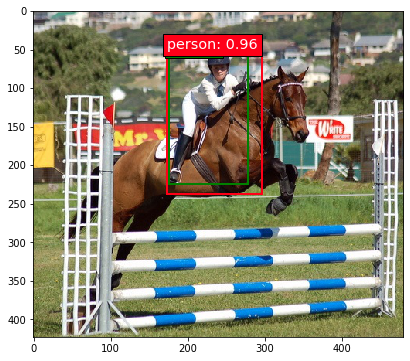

In [0]:
# 5: Draw the predicted boxes onto the image

# Set the colors for the bounding boxes
colors = plt.cm.hsv(np.linspace(0, 1, n_classes+1)).tolist()
classes = ['background', 'person']

plt.figure(figsize=(10,6))
plt.imshow(batch_original_images[i])

current_axis = plt.gca()

for box in batch_original_labels[i]:
    xmin = box[1]
    ymin = box[2]
    xmax = box[3]
    ymax = box[4]
    label = '{}'.format(classes[int(box[0])])
    current_axis.add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, color='green', fill=False, linewidth=2))  
    current_axis.text(xmin, ymin, label, size='x-large', color='white', bbox={'facecolor':'green', 'alpha':1.0})

for box in y_pred_decoded_inv[i]:
    xmin = box[2]
    ymin = box[3]
    xmax = box[4]
    ymax = box[5]
    color = colors[int(box[0])]
    label = '{}: {:.2f}'.format(classes[int(box[0])], box[1])
    current_axis.add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, color=color, fill=False, linewidth=2))  
    current_axis.text(xmin, ymin, label, size='x-large', color='white', bbox={'facecolor':color, 'alpha':1.0})